In [3]:
import pandas as pd

file_path = (r"C:\Patient-Readmission-Prediction\hospital_readmissions.csv")

df = pd.read_csv(file_path)

print("Shape:", df.shape)
print("\nColumns:")
print(df.columns.tolist())


Shape: (25000, 17)

Columns:
['age', 'time_in_hospital', 'n_lab_procedures', 'n_procedures', 'n_medications', 'n_outpatient', 'n_inpatient', 'n_emergency', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'glucose_test', 'A1Ctest', 'change', 'diabetes_med', 'readmitted']


In [4]:
print("\nFirst 5 rows:")
print(df.head())

print("\nInfo:")
print(df.info())

target_col = 'readmitted'  # guessing; adjust once we see columns
if target_col in df.columns:
    print("\nTarget distribution:")
    print(df[target_col].value_counts())



First 5 rows:
       age  time_in_hospital  n_lab_procedures  n_procedures  n_medications  \
0  [70-80)                 8                72             1             18   
1  [70-80)                 3                34             2             13   
2  [50-60)                 5                45             0             18   
3  [70-80)                 2                36             0             12   
4  [60-70)                 1                42             0              7   

   n_outpatient  n_inpatient  n_emergency medical_specialty       diag_1  \
0             2            0            0           Missing  Circulatory   
1             0            0            0             Other        Other   
2             0            0            0           Missing  Circulatory   
3             1            0            0           Missing  Circulatory   
4             0            0            0  InternalMedicine        Other   

        diag_2       diag_3 glucose_test A1Ctest chan

readmitted
no     0.52984
yes    0.47016
Name: proportion, dtype: float64

Numeric summary:
       time_in_hospital  n_lab_procedures  n_procedures  n_medications  \
count       25000.00000       25000.00000  25000.000000   25000.000000   
mean            4.45332          43.24076      1.352360      16.252400   
std             3.00147          19.81862      1.715179       8.060532   
min             1.00000           1.00000      0.000000       1.000000   
25%             2.00000          31.00000      0.000000      11.000000   
50%             4.00000          44.00000      1.000000      15.000000   
75%             6.00000          57.00000      2.000000      20.000000   
max            14.00000         113.00000      6.000000      79.000000   

       n_outpatient   n_inpatient   n_emergency  
count  25000.000000  25000.000000  25000.000000  
mean       0.366400      0.615960      0.186600  
std        1.195478      1.177951      0.885873  
min        0.000000      0.000000      0.

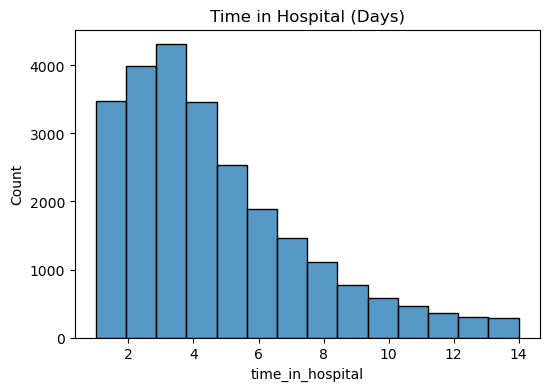

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt


print(df['readmitted'].value_counts(normalize=True))


print("\nNumeric summary:")
print(df[['time_in_hospital', 'n_lab_procedures', 'n_procedures',
          'n_medications', 'n_outpatient', 'n_inpatient', 'n_emergency']].describe())


plt.figure(figsize=(6,4))
sns.histplot(df['time_in_hospital'], kde=False, bins=14)
plt.title('Time in Hospital (Days)')
plt.show()


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

X = df.drop('readmitted', axis=1)
y = df['readmitted'].map({'no': 0, 'yes': 1})  # binary target

numeric_features = ['time_in_hospital', 'n_lab_procedures', 'n_procedures',
                    'n_medications', 'n_outpatient', 'n_inpatient', 'n_emergency']

categorical_features = ['age', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3',
                        'glucose_test', 'A1Ctest', 'change', 'diabetes_med']

numeric_transformer = 'passthrough'

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       0.60      0.78      0.68      2649
           1       0.63      0.41      0.50      2351

    accuracy                           0.61      5000
   macro avg       0.61      0.60      0.59      5000
weighted avg       0.61      0.61      0.59      5000

ROC-AUC: 0.644979229419575


In [7]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ))
])

rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_rf))
print("ROC-AUC (RF):", roc_auc_score(y_test, y_proba_rf))


              precision    recall  f1-score   support

           0       0.62      0.70      0.66      2649
           1       0.61      0.51      0.55      2351

    accuracy                           0.61      5000
   macro avg       0.61      0.61      0.61      5000
weighted avg       0.61      0.61      0.61      5000

ROC-AUC (RF): 0.6473717279571803


In [8]:
clf_weighted = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

clf_weighted.fit(X_train, y_train)
y_pred_w = clf_weighted.predict(X_test)
y_proba_w = clf_weighted.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_w))
print("ROC-AUC (weighted LR):", roc_auc_score(y_test, y_proba_w))


              precision    recall  f1-score   support

           0       0.62      0.71      0.66      2649
           1       0.60      0.50      0.55      2351

    accuracy                           0.61      5000
   macro avg       0.61      0.61      0.60      5000
weighted avg       0.61      0.61      0.61      5000

ROC-AUC (weighted LR): 0.6451084885687544


In [9]:
import numpy as np

rf_model = rf_clf.named_steps['model']
ohe = rf_clf.named_steps['preprocessor'].named_transformers_['cat']

cat_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(cat_feature_names)

importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

top_n = 15
for i in range(top_n):
    print(f"{i+1}. {all_feature_names[indices[i]]}: {importances[indices[i]]:.4f}")


1. n_lab_procedures: 0.1357
2. n_medications: 0.1206
3. time_in_hospital: 0.0845
4. n_inpatient: 0.0800
5. n_procedures: 0.0543
6. n_outpatient: 0.0326
7. n_emergency: 0.0229
8. diag_3_Other: 0.0210
9. diag_2_Other: 0.0201
10. diag_2_Circulatory: 0.0198
11. diag_3_Circulatory: 0.0198
12. medical_specialty_Missing: 0.0186
13. diag_1_Circulatory: 0.0184
14. age_[70-80): 0.0177
15. diag_1_Other: 0.0177
